# Part Combination Space Exploration

This is a notebook developed to leverage the new SysML v2 semantics for nested features and instantiation of models to generate instances of M1 system models as feedstock for analysis pipelines.

In [1]:
import requests
import getpass
import math

from __future__ import print_function

import time
import sysml_v2_api_client
from sysml_v2_api_client.rest import ApiException
from pprint import pprint

import json
import networkx as NX
import matplotlib.pyplot as plt

import random
import copy

import pymbe.api as pm
from pymbe.model_loading import ModelingSession as Session
from pymbe.interpretation.interpretation import RandomGenerationStrategy as RGS

In [2]:
import pymbe.query as pmQuery

# Configure API Server Connection

In [3]:
sysml_api_base_url = 'http://sysml2-sst.intercax.com:9000'

## Activate APIs

Connect the API classes to the server

In [4]:
configuration = sysml_v2_api_client.Configuration(
    host = sysml_api_base_url
)

projects_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    project_api_instance = sysml_v2_api_client.ProjectApi(api_client)
    
commits_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    commits_api_instance = sysml_v2_api_client.CommitApi(api_client)
    
elements_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    elements_api_instance = sysml_v2_api_client.ElementApi(api_client)

## Pull down commits and elements catalogs

With the API handles, use the pre-built methods to get lists of commits and elements.

In [5]:
project_api_instance

In [6]:
kerbal_proj = [my_proj for my_proj in project_api_instance.get_projects() if my_proj.name.find('Kerbal') > -1][0]
kerbal_proj

{'id': '03e3cdfe-8d90-4fc3-a414-9a188203d349',
 'name': 'Kerbal Sat Mar 13 14:07:34 UTC 2021',
 'type': 'Project'}

In [7]:
try:
    # Get commits by project
    commits_response = commits_api_instance.get_commits_by_project(kerbal_proj.id)
    pprint(commits_response)
except ApiException as e:
    print("Exception when calling CommitApi->get_commits_by_project: %s\n" % e)

[{'change': None,
 'containing_project': {'id': '03e3cdfe-8d90-4fc3-a414-9a188203d349'},
 'id': 'e8d87282-87a8-4b3e-8d42-2ecc73aa5b74',
 'previous_commit': None,
 'type': 'Commit'}]


In [8]:
elements = []

try:
    # Get commits by project
    elements = elements_api_instance.get_elements_by_project_commit(kerbal_proj.id, commits_response[0].id)
except ApiException as e:
    print("Exception when calling ElementApi->get_elements_by_project_commit: %s\n" % e)

In [9]:
len(elements)

100

In [10]:
pprint(elements[0])

{'id': '000f78ae-e890-4f81-847c-f9bf976abe1b',
 'identifier': '000f78ae-e890-4f81-847c-f9bf976abe1b',
 'type': 'PartUsage'}


# Gather Element Data

Since the generated API doesn't have much detail for elements, need to do this more hands-on.

Not elegant below to just have a larger page size, should implement paging later on.

In [11]:
elements_url = (sysml_api_base_url +
                '/projects/{0}/commits/{1}/elements?page[size]=2000').format(kerbal_proj.id, commits_response[0].id)

In [12]:
elements_url

'http://sysml2-sst.intercax.com:9000/projects/03e3cdfe-8d90-4fc3-a414-9a188203d349/commits/e8d87282-87a8-4b3e-8d42-2ecc73aa5b74/elements?page[size]=2000'

In [13]:
elements_response = requests.get(
    elements_url
)

In [14]:
elements_data = elements_response.json()

Split the elements into relationships and non-relationships. This will let us work with graph representations and a graph understanding of the underlying model.

In [15]:
len(elements_data)

506

In [16]:
non_relations = [non_relation for non_relation in elements_data if not 'relatedElement' in non_relation]

In [17]:
relations = [relation for relation in elements_data if 'relatedElement' in relation]

In [18]:
len(non_relations)

212

In [19]:
len(relations)

294

Survey which and how many metatypes are in the model.

In [20]:
metatypes = []
for nr in elements_data:
    if nr['@type'] not in metatypes:
        metatypes.append(nr['@type'])
        
metatypes

['PartUsage',
 'Redefinition',
 'EndFeatureMembership',
 'FeatureMembership',
 'LiteralInteger',
 'AttributeUsage',
 'Subsetting',
 'Membership',
 'FeatureValue',
 'Superclassing',
 'ReturnParameterMembership',
 'LiteralReal',
 'Succession',
 'ActionUsage',
 'Feature',
 'FeatureReferenceExpression',
 'PartDefinition',
 'MultiplicityRange',
 'ResultExpressionMembership',
 'SourceEnd',
 'FeatureTyping',
 'TransitionFeatureMembership',
 'ReferenceUsage',
 'Expression',
 'ItemDefinition',
 'Import',
 'ParameterMembership',
 'TargetEnd',
 'AcceptActionUsage',
 'Package',
 'TransitionUsage',
 'OperatorExpression',
 'StateUsage',
 'InvocationExpression',
 'StateDefinition',
 'ActionDefinition',
 'Function']

Create a working session for the model and feed it the serialized data. The working session will also generate useful graphs to inspect later in this workbook.

In [21]:
working_model = Session()
working_model.thaw_json_data(elements_data)

## Show Computed Graphs

### Superclassing Graph

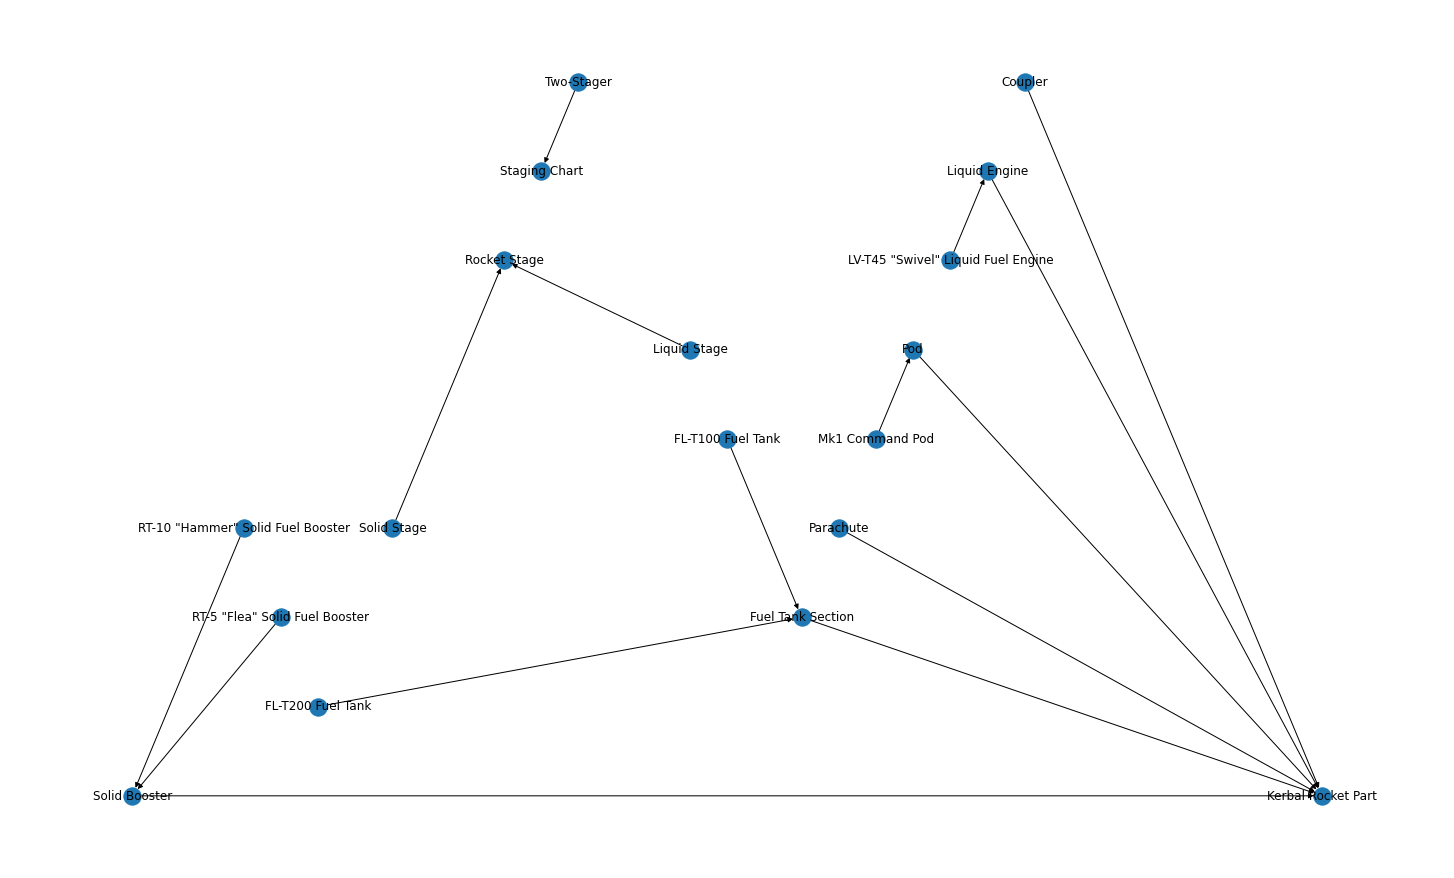

In [22]:
super_labels = NX.get_node_attributes(working_model.graph_manager.superclassing_graph,'name')

plt.figure(figsize=(20, 12))

NX.draw_planar(working_model.graph_manager.superclassing_graph,
               labels=super_labels)

### Banded Attribute Graph

In [23]:
list(working_model.graph_manager.banded_featuring_graph.successors('f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1'))

['64811484-97f6-442e-ab02-cd5247255cab']

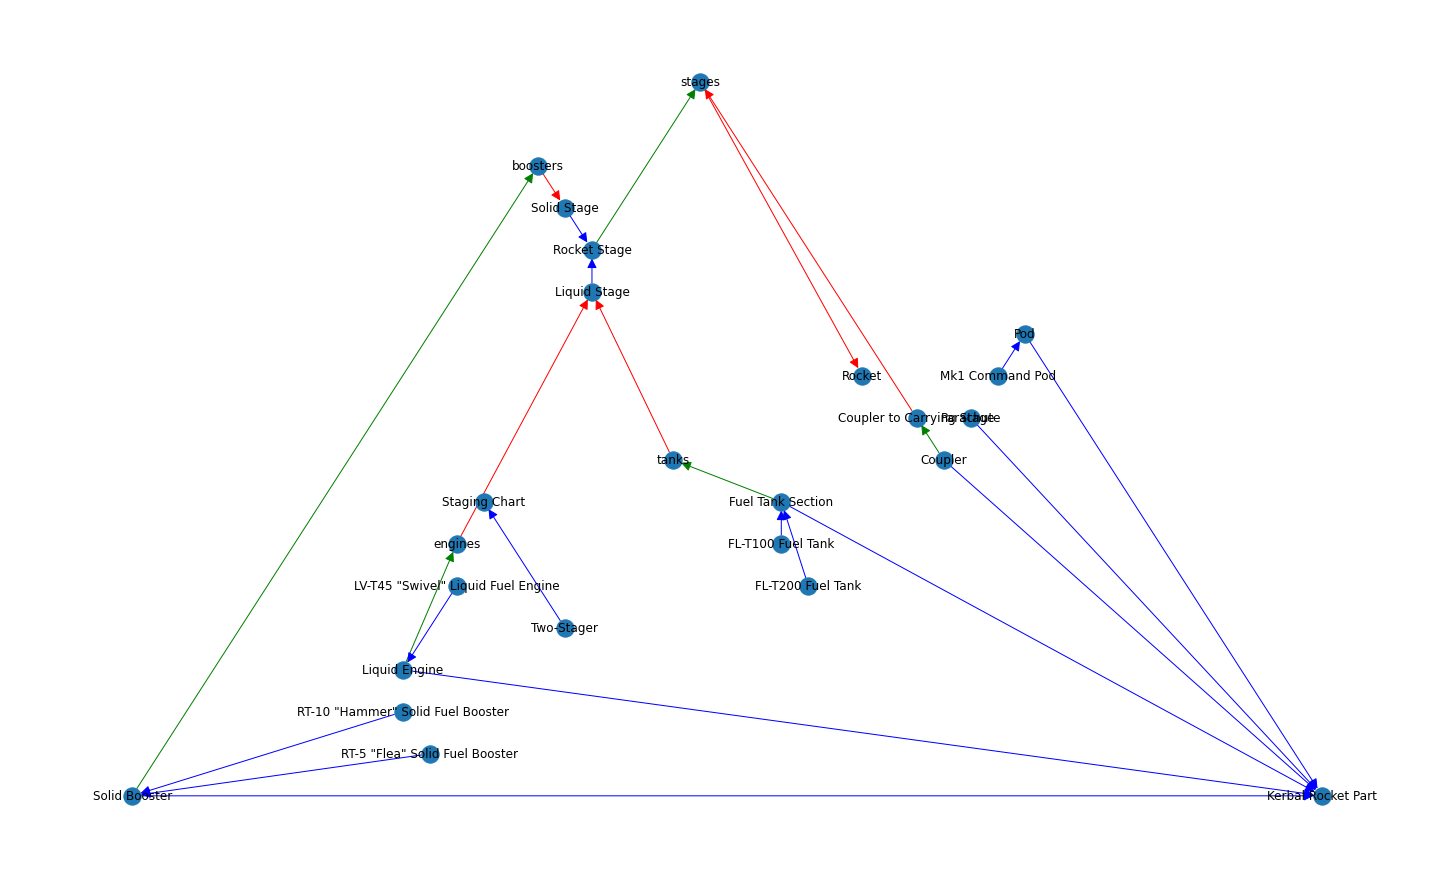

In [24]:
banded_labels = NX.get_node_attributes(working_model.graph_manager.banded_featuring_graph,'name')

edge_kinds = NX.get_edge_attributes(working_model.graph_manager.banded_featuring_graph,'kind')
colors = {}

for key, value in edge_kinds.items():
    if value == 'Superclassing':
        colors.update({key: 'b'})
    elif value == 'FeatureTyping^-1':
        colors.update({key: 'g'})
    elif value == 'FeatureMembership^-1':
        colors.update({key: 'r'})

plt.figure(figsize=(20, 12))

NX.draw_planar(working_model.graph_manager.banded_featuring_graph,
               labels=banded_labels,
              edge_color=colors.values(),
              arrowsize=20)

I think what we want is to see the chain of superclasses from a feature's owner and compare that to the path through redefinition to classifiers.

[
    edge
    for edge in lpg.graph.edges
    if edge[2] in ("ReturnParameterMembership", "Superclassing")
]

In [25]:
att_uses = working_model.get_all_of_metaclass(metaclass_name="AttributeUsage")

## Inspect Part Usages

In [26]:
part_uses = working_model.get_all_of_metaclass(metaclass_name='PartUsage')

In [27]:
len(part_uses)

5

In [28]:
['{0} has multiplicity {1}..{2}'.format(
    part_use['name'],
    working_model.feature_lower_multiplicity(part_use['@id']),
    working_model.feature_upper_multiplicity(part_use['@id'])
) for part_use in part_uses]

['tanks has multiplicity 0..30',
 'boosters has multiplicity 0..8',
 'Coupler to Carrying Stage has multiplicity 0..8',
 'engines has multiplicity 0..8',
 'stages has multiplicity 1..5']

Get feature types.

In [29]:
feature_types = [feature_type for feature_type in relations if feature_type['@type'] == 'FeatureTyping']

# Generate Instances

With the base semantic model in hand, begin to apply the rules to generate our system alternatives.

## Find number of instances for feature last positions

In SysML, the default type is PartDefinition, which is a Classifier, meaning the minimal interpretation of length one (the specific instance). Nesting parts then have an interpretation as expected by systems engineers, namely that the instances "stack" in order to provide a navigation from top-level assembly to leaf component.

In [30]:
['{0} needs {1} instances of type {2}'.format(
    part_use['name'],
    working_model.feature_upper_multiplicity(part_use['@id']),
    working_model.graph_manager.get_feature_type_name(part_use['@id'])
) for part_use in part_uses]

['tanks needs 30 instances of type Fuel Tank Section',
 'boosters needs 8 instances of type Solid Booster',
 'Coupler to Carrying Stage needs 8 instances of type Coupler',
 'engines needs 8 instances of type Liquid Engine',
 'stages needs 5 instances of type Rocket Stage']

Automatically shorten names so that sequences remain readable when printed.

In [31]:
shorten_pre_bake = {
    'RT-10 "Hammer" Solid Fuel Booster': "RT-10",
    'RT-5 "Flea" Solid Fuel Booster': "RT-5",
    'LV-T45 "Swivel" Liquid Fuel Engine': "LV-T45",
    'FL-T100 Fuel Tank': "FL-T100",
    'FL-T200 Fuel Tank': "FL-T200"
}

## Determine the size of the universe of instances needed for creating alternatives

Use feature membership together with multiplicity to decide how many individuals are needed.

In [32]:
working_model.graph_manager.roll_up_upper_multiplicities()

{'000f78ae-e890-4f81-847c-f9bf976abe1b': 150,
 '5caca345-39a8-4125-9387-3a4026b59700': 40,
 'b1e046e2-dca5-45ef-97c4-a54e15f87aea': 40,
 'cd081fb5-d4b7-42bc-880b-9f4cf2517394': 40,
 'f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1': 5}

In [33]:
[(working_model.get_name_by_id(key), mult) for key, mult in
    working_model.graph_manager.roll_up_upper_multiplicities().items()
]

[('tanks', 150),
 ('boosters', 40),
 ('Coupler to Carrying Stage', 40),
 ('engines', 40),
 ('stages', 5)]

### Subdivide Abstract Feature Types

Look at the feature types for where they are abstract and then generate instances from the more specific types.

In [34]:
abstract_types = []
for typ in working_model.graph_manager.superclassing_graph.nodes():
    ele_data = working_model.get_data_by_id(ele_id=typ)
    if ele_data['isAbstract']:
        abstract_types.append(ele_data)
        
print([abstract['name'] for abstract in abstract_types])

['Solid Booster', 'Fuel Tank Section', 'Liquid Engine', 'Rocket Stage']


In [35]:
[working_model.get_name_by_id(definite)
 for definite in working_model.graph_manager.partition_abstract_type(abstract_type_id=abstract_types[3]['@id'])]

['Liquid Stage', 'Solid Stage']

## Generate Random Alternatives

Start creating the alternatives with random draws on multiplicity. This will be our space for investigation for weights, thrust-to-weight ratios at stage ignitions, delta-Vs, and initial and burnout masses.

In [36]:
working_model.get_name_by_id(ele_id='000f78ae-e890-4f81-847c-f9bf976abe1b')

'tanks'

In [37]:
generator = RGS(number_of_cases=2, model_session=working_model, short_names=shorten_pre_bake)

Thrust is under RT-10 "Hammer" Solid Fuel Booster
Thrust is under RT-5 "Flea" Solid Fuel Booster
Thrust is under Solid Booster
Full Mass is under FL-T100 Fuel Tank
Full Mass is under FL-T200 Fuel Tank
Full Mass is under Fuel Tank Section
Empty Mass is under FL-T100 Fuel Tank
Empty Mass is under FL-T200 Fuel Tank
Empty Mass is under Fuel Tank Section
Specific Impulse is under RT-5 "Flea" Solid Fuel Booster
Specific Impulse is under RT-10 "Hammer" Solid Fuel Booster
Specific Impulse is under Solid Booster
Empty Mass is under RT-10 "Hammer" Solid Fuel Booster
Empty Mass is under RT-5 "Flea" Solid Fuel Booster
Empty Mass is under Solid Booster
Thrust is under LV-T45 "Swivel" Liquid Fuel Engine
Thrust is under Liquid Engine
Mass is under LV-T45 "Swivel" Liquid Fuel Engine
Mass is under Kerbal Rocket Part
Specific Impulse is under LV-T45 "Swivel" Liquid Fuel Engine
Specific Impulse is under Liquid Engine
Full Mass is under RT-10 "Hammer" Solid Fuel Booster
Full Mass is under RT-5 "Flea" Soli

In [38]:
generator.pprint_classifier_solution(solution_no=0)

FL-T200 Fuel Tank, id = c2501561-e875-4c47-8e88-65ddd846d20b, size = 50
[FL-T200#1, FL-T200#2, FL-T200#3, FL-T200#4, FL-T200#5]
FL-T100 Fuel Tank, id = 5260380b-6fda-43cc-993f-5df58868edbb, size = 100
[FL-T100#1, FL-T100#2, FL-T100#3, FL-T100#4, FL-T100#5]
RT-10 "Hammer" Solid Fuel Booster, id = 276d0623-a352-49cd-8faa-132792ec156a, size = 40
[RT-10#1, RT-10#2, RT-10#3, RT-10#4, RT-10#5]
RT-5 "Flea" Solid Fuel Booster, id = c29c33af-197a-426a-b2a3-b222d2f21307, size = 0
[]
LV-T45 "Swivel" Liquid Fuel Engine, id = 7e8c5105-bdd1-4cde-9133-c17ab1183f6a, size = 40
[LV-T45#1, LV-T45#2, LV-T45#3, LV-T45#4, LV-T45#5]
Liquid Stage, id = f25193df-abf0-478b-997d-dbee3895090e, size = 4
[LS#1, LS#2, LS#3, LS#4]
Solid Stage, id = 0b2ea820-ba6b-4f8a-a898-8694dc0a247d, size = 1
[SS#1]
Coupler, id = db9b21bf-1157-4fa2-88b9-4389884fcd89, size = 40
[Coupler#1, Coupler#2, Coupler#3, Coupler#4, Coupler#5]
Parachute, id = 156f9c43-0fbe-425b-89b4-db1aeeafb7c5, size = 0
[]
Two-Stager, id = 9113498a-cc6b-4bb9

In [39]:
generator.pprint_attribute_solution(solution_no=0)

Thrust::RT-10 "Hammer" Solid Fuel Booster, id = de02c870-1658-4a34-bd03-832f8efa741d, size = 40
[[RT-10#1, RT-10#1.Thrust (unset)], [RT-10#2, RT-10#2.Thrust (unset)], [RT-10#3, RT-10#3.Thrust (unset)], [RT-10#4, RT-10#4.Thrust (unset)], [RT-10#5, RT-10#5.Thrust (unset)]]
Thrust::RT-5 "Flea" Solid Fuel Booster, id = 86f2aed2-3801-420a-8df0-665d6b69c193, size = 0
[]
Thrust::Solid Booster, id = 34294966-7022-4b19-bec9-e92da83702a9, size = 40
[[RT-10#1, RT-10#1.Thrust (unset)], [RT-10#2, RT-10#2.Thrust (unset)], [RT-10#3, RT-10#3.Thrust (unset)], [RT-10#4, RT-10#4.Thrust (unset)], [RT-10#5, RT-10#5.Thrust (unset)]]
Full Mass::FL-T100 Fuel Tank, id = 0b4921a6-6923-40a2-941c-ac726cc2eb07, size = 100
[[FL-T100#1, FL-T100#1.Full Mass (unset)], [FL-T100#2, FL-T100#2.Full Mass (unset)], [FL-T100#3, FL-T100#3.Full Mass (unset)], [FL-T100#4, FL-T100#4.Full Mass (unset)], [FL-T100#5, FL-T100#5.Full Mass (unset)]]
Full Mass::FL-T200 Fuel Tank, id = 5de9ac2d-2879-4e44-978b-52307c4fd698, size = 50
[[F

In [40]:
generator.pprint_feature_solution(solution_no=0)

Liquid Stage, id = f25193df-abf0-478b-997d-dbee3895090e, size = 4
[[LS#1], [LS#2], [LS#3], [LS#4]]
engines, id = cd081fb5-d4b7-42bc-880b-9f4cf2517394, size = 25
[[LS#1, LV-T45#14], [LS#1, LV-T45#13], [LS#1, LV-T45#22], [LS#1, LV-T45#33], [LS#1, LV-T45#1]]
tanks, id = 000f78ae-e890-4f81-847c-f9bf976abe1b, size = 60
[[LS#1, FL-T200#23], [LS#1, FL-T200#1], [LS#1, FL-T200#5], [LS#1, FL-T100#39], [LS#1, FL-T200#28]]
Rocket, id = 64811484-97f6-442e-ab02-cd5247255cab, size = 1
[[Rocket#1]]
stages, id = f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1, size = 5
[[Rocket#1, SS#1], [Rocket#1, LS#4], [Rocket#1, LS#2], [Rocket#1, LS#3], [Rocket#1, LS#1]]
Coupler to Carrying Stage, id = b1e046e2-dca5-45ef-97c4-a54e15f87aea, size = 11
[[Rocket#1, LS#2, Coupler#25], [Rocket#1, LS#2, Coupler#40], [Rocket#1, LS#2, Coupler#10], [Rocket#1, LS#2, Coupler#23], [Rocket#1, LS#2, Coupler#33]]
Solid Stage, id = 0b2ea820-ba6b-4f8a-a898-8694dc0a247d, size = 1
[[SS#1]]
boosters, id = 5caca345-39a8-4125-9387-3a4026b59700, siz

### Look at attribute values and feature types 

Build a graph where attribute usages are connected to other types and superclassing

In [41]:
for ft in working_model.get_all_of_metaclass(metaclass_name='FeatureMembership'):
    print(working_model.get_element_signature(ft))

, id 67812f5a-dfe6-4ac4-9600-936a85a1400e - > , id 454a8ebe-89b9-442b-a4ae-a7d4ab2a90c6 <FeatureMembership>
Thrust, id de02c870-1658-4a34-bd03-832f8efa741d - > RT-10 "Hammer" Solid Fuel Booster, id 276d0623-a352-49cd-8faa-132792ec156a <FeatureMembership>
Payload Mass, id dbff731a-593e-442c-99f0-a54001dea138 - > stages, id f5f406e8-b8a6-4f8b-a90e-01616a6cf1c1 <FeatureMembership>
Full Mass, id 0b4921a6-6923-40a2-941c-ac726cc2eb07 - > FL-T100 Fuel Tank, id 5260380b-6fda-43cc-993f-5df58868edbb <FeatureMembership>
Stage 1 Burn, id 753d2ff7-52f2-481f-80a8-87dcefa492ae - > Two-Stager, id 9113498a-cc6b-4bb9-9734-b023a7e099ed <FeatureMembership>
, id 1bab5ced-f3d0-42cc-9391-943ae61f3c15 - > , id e0c01246-d5ea-4f2f-87a1-feed644786e6 <FeatureMembership>
, id f5e6e4c7-66cb-43a7-8c14-cf50b332d5e5 - > , id 92cbcb02-bc53-4cf8-a8b1-f347db5c6526 <FeatureMembership>
Full Mass, id f912dc27-fc5e-48e8-abf7-29d3f47c913c - > Fuel Tank Section, id c90361d5-e456-4d96-aecf-b1130825f4fd <FeatureMembership>
Empty

## Investigate Literal Assignments and Expressions

In [42]:
expressions = [expr for expr in non_relations if 'Expression' in expr['@type']]

In [43]:
len(expressions)

11

In [71]:
def expression_signature(expr):
    if expr['@type'] == 'FeatureReferenceExpression':
        fre = working_model.get_data_by_id(expr['referent']['@id'])
        return working_model.get_name_by_id(fre['owner']['@id']) + '::' + fre['name']
    elif expr['@type'] == 'OperatorExpression':
        oper = expr['operator']
        paras = [expression_signature(working_model.get_data_by_id(para['@id'])) for para in expr['operand']]
        return str(oper) + ' (' + str(paras) + ')'
    elif expr['@type'] == 'Expression':
        result_name = working_model.get_name_by_id(expr['result']['@id'])
        inputs = [expression_signature(working_model.get_data_by_id(para['@id'])) for para in expr['input']]
        return 'f(' + ', '.join(inputs) + ') => ' + result_name
    elif expr['@type'] in ('ReferenceUsage', 'Feature', 'AttributeUsage', 'Function'):
        if expr['name'] is not None:
            return expr['name']
        else:
            return ''
    elif expr['@type'] == 'InvocationExpression':
        invoked = working_model.get_name_by_id(expr['type'][0]['@id'])
        inputs = [expression_signature(working_model.get_data_by_id(para['@id'])) for para in expr['input']]
        return invoked + '(' + str(inputs) + ')'
    else:
        return expr['@type']

In [69]:
expression_signature(expressions[9])

"collect (['Liquid Stage::engines', 'f(p) => $result'])"

In [79]:
expression_graph = NX.DiGraph()

In [80]:
for rel in relations:
    if rel['@type'] == 'ReturnParameterMembership':
        owner = working_model.get_data_by_id(rel['owningType']['@id'])
        para = working_model.get_data_by_id(rel['memberParameter']['@id'])
        
        expression_graph.add_node(owner['@id'], label=expression_signature(owner))
        expression_graph.add_node(para['@id'], label=expression_signature(para))
        expression_graph.add_edge(owner['@id'], para['@id'], kind='ReturnParameterMembership')
        
        print (expression_signature(owner) + ' =RPN=> ' + expression_signature(para))
    elif rel['@type'] == 'ParameterMembership':
        owner = working_model.get_data_by_id(rel['owningType']['@id'])
        para = working_model.get_data_by_id(rel['memberParameter']['@id'])
        
        expression_graph.add_node(owner['@id'], label=expression_signature(owner))
        expression_graph.add_node(para['@id'], label=expression_signature(para))
        expression_graph.add_edge(owner['@id'], para['@id'], kind='ParameterMembership')
        print (expression_signature(owner) + ' =PN=> ' + expression_signature(para))
    elif rel['@type'] == 'FeatureValue':
        feature = working_model.get_data_by_id(rel['owningRelatedElement']['@id'])
        value = working_model.get_data_by_id(rel['value']['@id'])
        
        expression_graph.add_node(feature['@id'], label=expression_signature(feature))
        expression_graph.add_node(value['@id'], label=expression_signature(value))
        expression_graph.add_edge(feature['@id'], value['@id'], kind='FeatureValue')
        
        feature_owner = working_model.get_data_by_id(feature['owningType']['@id'])
        
        if 'value' in value:
            print (expression_signature(value) + ' (' + str(value['value']) + \
                   ') value of ' + feature_owner['name'] + '::' + expression_signature(feature))
        else:
            print (expression_signature(value) + \
                   ' value of ' + feature_owner['name'] + '::' + expression_signature(feature))
            
    elif rel['@type'] == 'FeatureMembership':
        if 'Expression' in working_model.get_data_by_id(rel['memberFeature']['@id'])['@type']:
            if working_model.get_metaclass_by_id(rel['memberFeature']['@id']) != 'AttributeUsage':
                owner = working_model.get_data_by_id(rel['owningType']['@id'])
                expr = working_model.get_data_by_id(rel['memberFeature']['@id'])

                expression_graph.add_node(owner['@id'], label=expression_signature(owner))
                expression_graph.add_node(expr['@id'], label=expression_signature(expr))
                expression_graph.add_edge(owner['@id'], expr['@id'], kind='FeatureMembership')
            
            print (expression_signature(owner) + ' =FM=> ' + expression_signature(expr))
            
    elif rel['@type'] == 'FeatureTyping':
        if 'Expression' in working_model.get_data_by_id(rel['typedFeature']['@id'])['@type']:
            typ = working_model.get_data_by_id(rel['type']['@id'])
            expr = working_model.get_data_by_id(rel['typedFeature']['@id'])

            expression_graph.add_node(typ['@id'], label=expression_signature(typ))
            expression_graph.add_node(expr['@id'], label=expression_signature(expr))
            expression_graph.add_edge(expr['@id'], typ['@id'], kind='FeatureTyping')
            
            print (expression_signature(expr) + ' =FT=> ' + expression_signature(typ))

collect (['Liquid Stage::tanks', 'f(p) => $result']) =FM=> Liquid Stage::tanks
LiteralReal (140.0) value of RT-5 "Flea" Solid Fuel Booster::Specific Impulse
LiteralInteger =RPN=> $result
LiteralReal (167.97) value of LV-T45 "Swivel" Liquid Fuel Engine::Thrust
LiteralInteger =RPN=> $result
Fuel Tank Section::Full Mass =RPN=> $result
collect (['Liquid Stage::engines', 'f(p) => $result']) =FM=> f(p) => $result
collect (['Liquid Stage::engines', 'f(p) => $result']) =PN=> $collection
AcceptActionUsage =PN=> 
sum(['$collection']) =FM=> collect (['Liquid Stage::engines', 'f(p) => $result'])
LiteralReal =RPN=> $result
collect (['Liquid Stage::engines', 'f(p) => $result']) =RPN=> $result
LiteralInteger =RPN=> $result
AcceptActionUsage =PN=> 
LiteralReal (0.45) value of RT-5 "Flea" Solid Fuel Booster::Empty Mass
Liquid Stage::engines =RPN=> $result
AcceptActionUsage =PN=> 
collect (['Liquid Stage::tanks', 'f(p) => $result']) =RPN=> $result
LiteralReal =RPN=> $result
LiteralReal =RPN=> $result
Li

In [105]:
expression_value_pairs = []

for rel in relations:
    if rel['@type'] == 'FeatureValue':
        value = working_model.get_data_by_id(rel['value']['@id'])
        if 'Expression' in value['@type']:
            feature = working_model.get_data_by_id(rel['owningRelatedElement']['@id'])
            expression_value_pairs.append([feature['@id'], value['@id']])

In [106]:
len(expression_value_pairs)

1

In [123]:
context_dict = {}
def get_context_from_graph(graph, expr_values):
    for ev in expr_values:
        tree = NX.dfs_tree(graph, source=ev[1])
        for tree_node in tree.nodes():
            if 'Expression' in working_model.get_data_by_id(tree_node)['@type']:
                context_dict.update({tree_node: working_model.get_data_by_id(ev[0])['owningType']['@id']})

In [124]:
paint_context_on_graph(expression_graph, expression_value_pairs)

In [125]:
context_dict

{'4c4403fc-87c6-4e04-bdee-81b688ff09f7': 'f25193df-abf0-478b-997d-dbee3895090e',
 '60b2d33a-a357-4e04-9816-5b4d337808ef': 'f25193df-abf0-478b-997d-dbee3895090e',
 'e0c01246-d5ea-4f2f-87a1-feed644786e6': 'f25193df-abf0-478b-997d-dbee3895090e',
 '1bab5ced-f3d0-42cc-9391-943ae61f3c15': 'f25193df-abf0-478b-997d-dbee3895090e',
 '08ca6d04-9620-478e-bdda-b538e9676a5c': 'f25193df-abf0-478b-997d-dbee3895090e',
 'ec4368d6-0621-42ce-8feb-1b0827593df0': 'f25193df-abf0-478b-997d-dbee3895090e',
 '454a8ebe-89b9-442b-a4ae-a7d4ab2a90c6': 'f25193df-abf0-478b-997d-dbee3895090e',
 '67812f5a-dfe6-4ac4-9600-936a85a1400e': 'f25193df-abf0-478b-997d-dbee3895090e',
 '948963c8-0c61-488d-8f94-4aa2504bc5db': 'f25193df-abf0-478b-997d-dbee3895090e'}

Examine the expression graph and paint expression nodes with context for later evaluations.

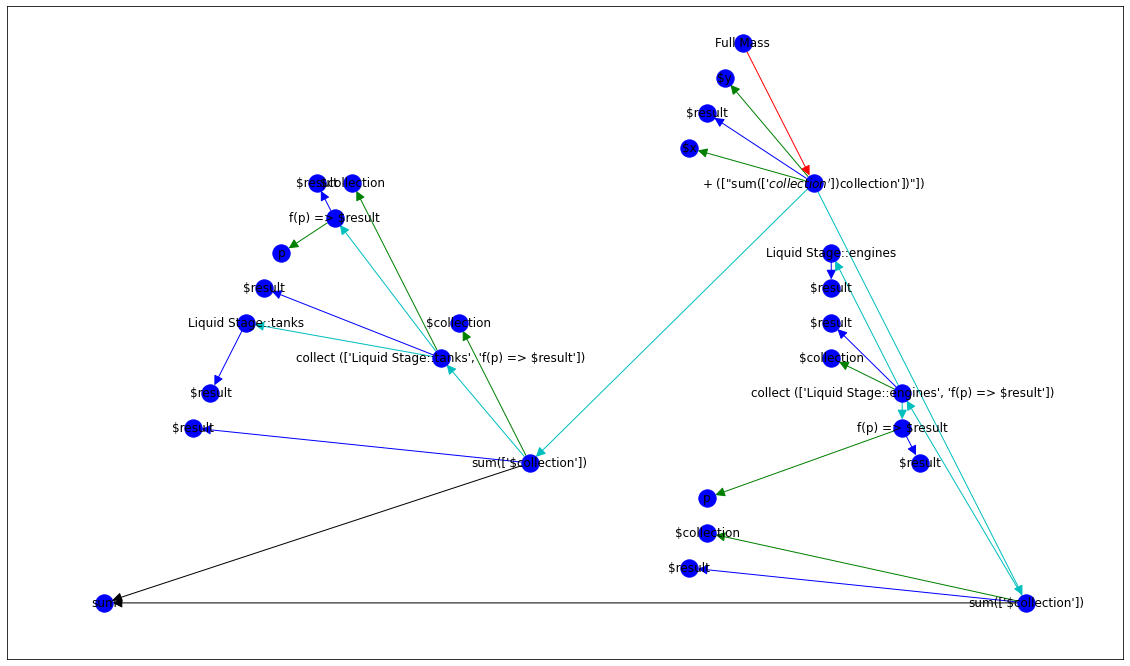

In [104]:
for comp in NX.connected_components(expression_graph.to_undirected()):
    connected_sub = NX.subgraph(expression_graph, list(comp))
    
    pos = NX.planar_layout(connected_sub)

    banded_labels = NX.get_node_attributes(connected_sub,'label')

    edge_kinds = NX.get_edge_attributes(connected_sub,'kind')
    colors = []
    
    rpm_edges = []
    pm_edges = []
    fv_edges = []
    ft_edges = []
    fm_edges = []
    
    for edg in connected_sub.edges.data("kind"):
        if edg[2] == 'ReturnParameterMembership':
            rpm_edges.append([edg[0], edg[1]])
        elif edg[2] == 'ParameterMembership':
            pm_edges.append([edg[0], edg[1]])
        elif edg[2] == 'FeatureValue':
            fv_edges.append([edg[0], edg[1]])
        elif edg[2] == 'FeatureTyping':
            ft_edges.append([edg[0], edg[1]])
        elif edg[2] == 'FeatureMembership':
            fm_edges.append([edg[0], edg[1]])
    
    # only plot non-trivial
    if len(comp) > 4:

        plt.figure(figsize=(20, 12))
        
        NX.draw_networkx_nodes(connected_sub, pos, nodelist=comp, node_color="b")
        
        NX.draw_networkx_edges(connected_sub, pos, edgelist=rpm_edges, edge_color="b", arrowsize=20)
        NX.draw_networkx_edges(connected_sub, pos, edgelist=ft_edges, edge_color="k", arrowsize=20)
        NX.draw_networkx_edges(connected_sub, pos, edgelist=pm_edges, edge_color="g", arrowsize=20)
        NX.draw_networkx_edges(connected_sub, pos, edgelist=fv_edges, edge_color="r", arrowsize=20)
        NX.draw_networkx_edges(connected_sub, pos, edgelist=fm_edges, edge_color="c", arrowsize=20)
        
        NX.draw_networkx_labels(connected_sub, pos, banded_labels, font_size=12)

        #NX.draw_planar(connected_sub,
        #               edgelist=connected_sub.edges,
        #               labels=banded_labels,
        #              edge_color=colors,
        #              arrowsize=20)

In [51]:
generator.attribute_dicts[0]

{'de02c870-1658-4a34-bd03-832f8efa741d': [[RT-10#1, RT-10#1.Thrust (unset)],
  [RT-10#2, RT-10#2.Thrust (unset)],
  [RT-10#3, RT-10#3.Thrust (unset)],
  [RT-10#4, RT-10#4.Thrust (unset)],
  [RT-10#5, RT-10#5.Thrust (unset)],
  [RT-10#6, RT-10#6.Thrust (unset)],
  [RT-10#7, RT-10#7.Thrust (unset)],
  [RT-10#8, RT-10#8.Thrust (unset)],
  [RT-10#9, RT-10#9.Thrust (unset)],
  [RT-10#10, RT-10#10.Thrust (unset)],
  [RT-10#11, RT-10#11.Thrust (unset)],
  [RT-10#12, RT-10#12.Thrust (unset)],
  [RT-10#13, RT-10#13.Thrust (unset)],
  [RT-10#14, RT-10#14.Thrust (unset)],
  [RT-10#15, RT-10#15.Thrust (unset)],
  [RT-10#16, RT-10#16.Thrust (unset)],
  [RT-10#17, RT-10#17.Thrust (unset)],
  [RT-10#18, RT-10#18.Thrust (unset)],
  [RT-10#19, RT-10#19.Thrust (unset)],
  [RT-10#20, RT-10#20.Thrust (unset)],
  [RT-10#21, RT-10#21.Thrust (unset)],
  [RT-10#22, RT-10#22.Thrust (unset)],
  [RT-10#23, RT-10#23.Thrust (unset)],
  [RT-10#24, RT-10#24.Thrust (unset)],
  [RT-10#25, RT-10#25.Thrust (unset)],
  [